# Reproduction of the paper of Weitz et al.

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

### Figure 1

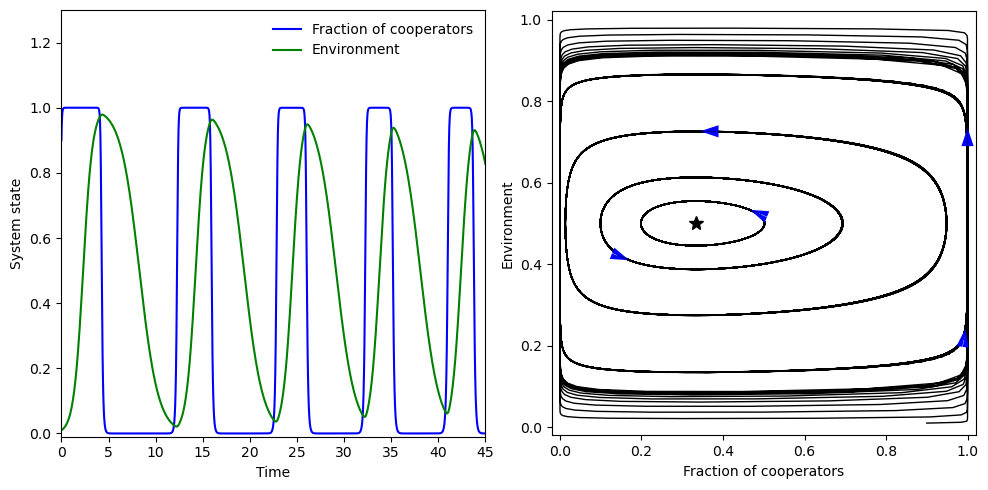

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def dynamics_symmetric(t, y, epsilon, theta, R, S, T, P):
    x, n = y
    
    # --- FIX: Clip variables to avoid numerical explosion ---
    x = np.clip(x, 0, 1)
    n = np.clip(n, 0, 1)
    # --------------------------------------------------------

    delta_PS = P - S
    delta_TR = T - R
    payoff_term = (1.0 - 2.0 * n) * (delta_PS + (delta_TR - delta_PS) * x)
    
    dxdt = (1.0 / epsilon) * x * (1.0 - x) * payoff_term
    dndt = n * (1.0 - n) * (-1.0 + (1.0 + theta) * x)
    
    return [dxdt, dndt]
def reproduce_figure_2():
    # Parameters from Weitz et al. 2016
    epsilon = 0.1
    theta = 2.0
    R, S, T, P = 3.0, 0.0, 5.0, 1.0

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # --- LEFT PANEL: Time Series ---
    # LSODA handles the "square wave" shape well
    sol = solve_ivp(dynamics_symmetric, (0, 45), [0.9, 0.01], 
                    t_eval=np.linspace(0, 45, 1000),
                    method='RK45',
                    args=(epsilon, theta, R, S, T, P),
                    max_step=0.1,    # Prevents jagged corners
                    rtol=1e-5,       # High precision relative
                    atol=1e-8)      # High precision absolute (Crucial!)
    
    ax = axes[0]
    ax.plot(sol.t, sol.y[0], 'b-', label='Fraction of cooperators')
    ax.plot(sol.t, sol.y[1], 'g-', label='Environment')
    ax.set_xlabel('Time')
    ax.set_ylabel('System state')
    ax.set_xlim(0, 45)
    ax.set_ylim(-0.01, 1.3)
    ax.legend(loc='upper right', frameon=False)

    # --- RIGHT PANEL: Phase Plane ---
    ax = axes[1]
    initial_conditions = [(0.9, 0.01), (0.8, 0.15), (0.7, 0.3), (0.5, 0.4), (0.4, 0.45)]
    
    for ic in initial_conditions:
        # Loop closure is very sensitive to tolerance here
        sol_orbit = solve_ivp(dynamics_symmetric, (0, 100), ic, 
                              t_eval=np.linspace(0, 100, 1000), # Smooth plotting
                              method='RK45',
                              args=(epsilon, theta, R, S, T, P),
                              max_step=0.1,
                              rtol=1e-5, 
                              atol=1e-8) 
        
        ax.plot(sol_orbit.y[0], sol_orbit.y[1], 'k-', lw=1.0)
        
        # Add Arrows
        idx = len(sol_orbit.t) // 4
        x_curr, n_curr = sol_orbit.y[0][idx], sol_orbit.y[1][idx]
        dx, dn = dynamics_symmetric(0, [x_curr, n_curr], epsilon, theta, R, S, T, P)
        norm = np.hypot(dx, dn)
        ax.arrow(x_curr, n_curr, dx/norm*0.001, dn/norm*0.001, 
                 shape='full', lw=0, length_includes_head=True, 
                 head_width=0.03, color='blue', zorder=5)

    # Plot Fixed Point 
    fixed_x = 1.0 / (1.0 + theta)
    fixed_n = 0.5
    ax.plot(fixed_x, fixed_n, 'k*', markersize=10)

    ax.set_xlabel('Fraction of cooperators')
    ax.set_ylabel('Environment')
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

reproduce_figure_2()

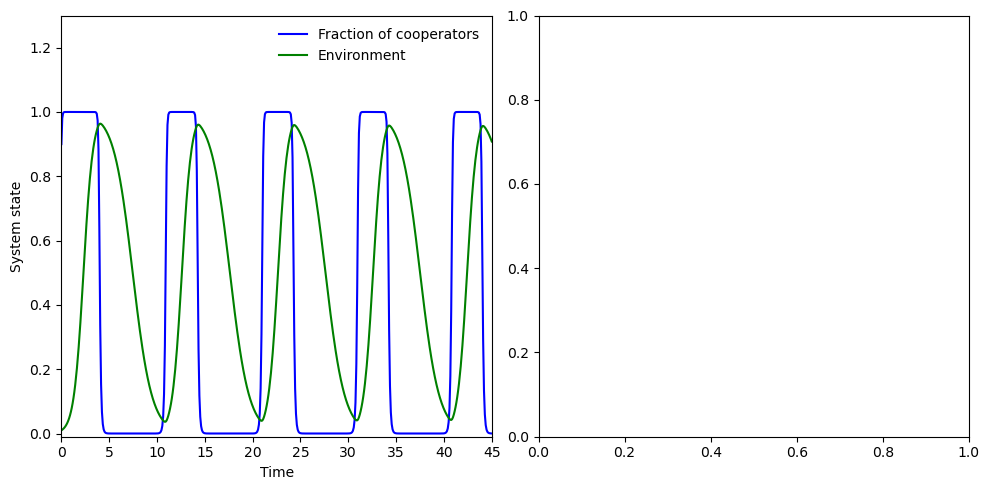

In [37]:
def reproduce_figure_2():
    # Parameters from Weitz et al. 2016
    epsilon = 0.1
    theta = 2.0
    R, S, T, P = 3.0, 0.0, 5.0, 1.0

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # --- LEFT PANEL: Time Series ---
    # Matches the smooth curves in Fig 2A
    sol = solve_ivp(dynamics_symmetric, (0, 45), [0.9, 0.01], 
                    method="BDF",
                    t_eval=np.linspace(0, 45, 500),
                    args=(epsilon, theta, R, S, T, P),
                    max_step=0.10, rtol=1e-7, atol=1e-11) #7, 11
    
    ax = axes[0]
    ax.plot(sol.t, sol.y[0], 'b-', label='Fraction of cooperators')
    ax.plot(sol.t, sol.y[1], 'g-', label='Environment')
    ax.set_xlabel('Time')
    ax.set_ylabel('System state')
    ax.set_xlim(0, 45)
    ax.set_ylim(-0.01, 1.3)
    ax.legend(loc='upper right', frameon=False)
    
    plt.tight_layout()
    plt.show()

reproduce_figure_2()

Generating Figure 3...


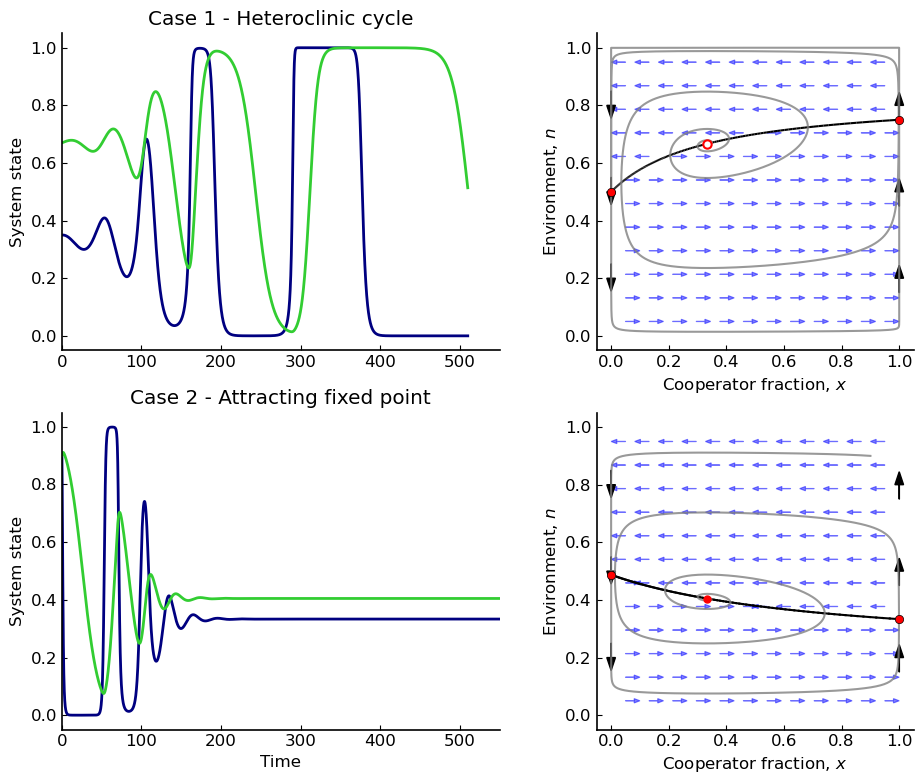

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ============================================================================
# 1. PLOTTING STYLE & CONFIGURATION
# ============================================================================
plt.rcParams.update({
    "font.size": 12,
    "font.family": "sans-serif",
    "lines.linewidth": 2,
    "axes.linewidth": 1.2,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "xtick.direction": "in",
    "ytick.direction": "in",
})

COLOR_COOP = '#000080'      # Navy Blue (x)
COLOR_ENV = '#32CD32'       # Lime Green (n)
COLOR_MANIFOLD_STABLE = 'black'
COLOR_MANIFOLD_UNSTABLE = 'black'  # Dashed
COLOR_FAST_ARROW = 'blue'
COLOR_SLOW_ARROW = 'black'
COLOR_BIFURCATION = 'red'

# ============================================================================
# 2. CORE DYNAMICS ENGINE
# ============================================================================

def get_payoff_matrix(n, A0, A1):
    """Linearly interpolate payoff matrix: A(n) = (1-n)A0 + nA1"""
    return (1 - n) * A0 + n * A1

def get_fast_parameters(n, A0, A1):
    """
    Returns coefficients (a, b) for the fast dynamics x' = x(1-x)(ax + b).
    """
    A = get_payoff_matrix(n, A0, A1)
    b = A[0, 1] - A[1, 1]
    a = (A[0, 0] - A[1, 0]) - b
    return a, b

def dynamics_general(t, y, epsilon, theta, A0, A1):
    x, n = y

    # 1. Get Payoffs for current n
    # Eq 21: A(n) = (1-n)A0 + nA1
    A_n = get_payoff_matrix(n, A0, A1)
    
    # 2. Extract fitness values directly
    # Row 0 = Cooperator Payoffs, Row 1 = Defector Payoffs
    R, S = A_n[0, 0], A_n[0, 1]
    T, P = A_n[1, 0], A_n[1, 1]
    
    # 3. Calculate Fitness (r1, r2)
    r1_val = R * x + S * (1 - x)
    r2_val = T * x + P * (1 - x)
    
    # 4. Equations (Rescaled time tau, Eq. 20)
    # x' = x(1-x)(r1 - r2)      <-- No epsilon here
    dxdt = x * (1 - x) * (r1_val - r2_val)
    
    # n' = epsilon * n(1-n)...  <-- Epsilon is here
    dndt = epsilon * n * (1 - n) * (-1 + (1 + theta) * x)
    
    return [dxdt, dndt]

# ============================================================================
# 3. ANALYTICAL HELPERS (Bifurcations & Stability)
# ============================================================================

def find_bifurcations(A0, A1):
    """
    Find saddle-node bifurcation points where the interior fixed point
    collides with the boundary (x=0 or x=1).
    """
    bifs = []
    
    # Coeffs are linear in n: P(n) = P0 + n(P1 - P0)
    a0, b0 = get_fast_parameters(0, A0, A1)
    a1, b1 = get_fast_parameters(1, A0, A1)
    
    # 1. Check b(n) = 0
    denom_b = b1 - b0
    if abs(denom_b) > 1e-9:
        n_0 = -b0 / denom_b
        if 0 <= n_0 <= 1:
            bifs.append((0, n_0)) # Bifurcation on x=0 line
            
    # 2. Check a(n) + b(n) = 0
    val0 = a0 + b0
    val1 = a1 + b1
    denom_val = val1 - val0
    if abs(denom_val) > 1e-9:
        n_1 = -val0 / denom_val
        if 0 <= n_1 <= 1:
            bifs.append((1, n_1)) # Bifurcation on x=1 line
            
    return bifs

def get_manifold_stability(n, A0, A1):
    """
    Determine if the interior fixed point is stable or unstable.
    """
    a, b = get_fast_parameters(n, A0, A1)
    return "stable" if a < 0 else "unstable"

def plot_fast_slow_phase_plane(ax, A0, A1, traj_sol, title_text):
    """Helper to draw the detailed phase planes for Fig 3."""
    
    # 1. Critical Manifolds
    n_space = np.linspace(0, 1, 600)
    x_c_list = []
    n_c_list = []
    stability_list = []
    
    for n in n_space:
        a, b = get_fast_parameters(n, A0, A1)
        if abs(a) > 1e-6:
            x_val = -b / a
            if 0 <= x_val <= 1:
                x_c_list.append(x_val)
                n_c_list.append(n)
                stability_list.append(get_manifold_stability(n, A0, A1))
            else:
                x_c_list.append(np.nan); n_c_list.append(np.nan); stability_list.append(None)
        else:
            x_c_list.append(np.nan); n_c_list.append(np.nan); stability_list.append(None)
            
    # Plot segments based on stability
    for i in range(len(x_c_list) - 1):
        if np.isnan(x_c_list[i]) or np.isnan(x_c_list[i+1]):
            continue
        style = '-' if stability_list[i] == 'stable' else '--'
        ax.plot(x_c_list[i:i+2], n_c_list[i:i+2], color='black', ls=style, lw=1.5)

    # 2. Fast Dynamics Arrows (Double Arrows - Blue)
    y_grid = np.linspace(0.05, 0.95, 12)
    x_grid = np.linspace(0.05, 0.95, 12)
    for n in y_grid:
        a, b = get_fast_parameters(n, A0, A1)
        for x in x_grid:
            dx = a*x + b 
            if abs(dx) > 1e-4:
                direction = np.sign(dx)
                ax.arrow(x, n, direction*0.03, 0, 
                         head_width=0.015, head_length=0.02, 
                         fc=COLOR_FAST_ARROW, ec=COLOR_FAST_ARROW, alpha=0.5, lw=0.8)

    # 3. Slow Dynamics Arrows (Single Arrows - Black on boundaries)
    for y_arrow in [0.2, 0.5, 0.8]:
        ax.arrow(0, y_arrow+0.05, 0, -0.05, head_width=0.03, fc='k', ec='k')
        ax.arrow(1, y_arrow-0.05, 0, 0.05, head_width=0.03, fc='k', ec='k')

    # 4. Bifurcation Points (Red Circles)
    bifs = find_bifurcations(A0, A1)
    for bx, bn in bifs:
        ax.plot(bx, bn, 'ro', markersize=6, mec='k', mew=0.5, zorder=10)

    # 5. Realized Trajectory (Gray)
    if traj_sol is not None:
        ax.plot(traj_sol.y[0], traj_sol.y[1], color='gray', lw=1.5, alpha=0.8)

    # Styling
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_aspect('equal')
    ax.set_xlabel('Cooperator fraction, $x$')
    ax.set_ylabel('Environment, $n$')

def reproduce_figure_3():
    """Reproduces Figure 3: Fast-Slow Dynamics."""
    print("Generating Figure 3...")
    
    epsilon = 0.1
    theta = 2.0
    
    # --- Case 1: Heteroclinic Cycle (Top) ---
    A0_het = np.array([[3.5, 1.0], [2.0, 0.75]])
    A1_het = np.array([[4.0, 1.0], [4.5, 1.25]])
    
    # Initial Condition visually estimated to match trace starting position
    y0_het = [0.35, 0.67] 
    
    sol_het = solve_ivp(dynamics_general, (0, 510), y0_het, 
                        args=(epsilon, theta, A0_het, A1_het),
                        rtol=1e-10, atol=1e-13, max_step=0.01)

    # --- Case 2: Attracting Fixed Point (Bottom) ---
    A0_fix = np.array([[3.5, 1.0], [2.0, 0.05]])
    A1_fix = np.array([[4.0, 1.0], [7.0, 2.0]])
    
    # Initial Condition visually estimated
    y0_fix = [0.9, 0.9]
    
    sol_fix = solve_ivp(dynamics_general, (0, 550), y0_fix, 
                        args=(epsilon, theta, A0_fix, A1_fix),
                        rtol=1e-10, atol=1e-13, max_step=0.1)

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    
    # Top Row
    axes[0,0].plot(sol_het.t, sol_het.y[0], color=COLOR_COOP)
    axes[0,0].plot(sol_het.t, sol_het.y[1], color=COLOR_ENV)
    axes[0,0].set_xlim(0, 550)
    axes[0,0].set_ylabel('System state')
    axes[0,0].set_title('Case 1 - Heteroclinic cycle')
    
    plot_fast_slow_phase_plane(axes[0,1], A0_het, A1_het, sol_het, "")
    
    # === [MODIFICATION STARTS HERE] ===
    # Draw Repeller (Unstable Fixed Point) for Top Right
    # x* = 1/(1+theta) = 1/3
    # n* = 2/3 (Analytically derived for these specific A0/A1 matrices)
    axes[0,1].plot(1.0/3.0, 2.0/3.0, marker='o', markersize=6, 
                   markerfacecolor='white', markeredgecolor='red', 
                   markeredgewidth=1.5, zorder=20)
    # === [MODIFICATION ENDS HERE] ===

    # Bottom Row
    axes[1,0].plot(sol_fix.t, sol_fix.y[0], color=COLOR_COOP)
    axes[1,0].plot(sol_fix.t, sol_fix.y[1], color=COLOR_ENV)
    axes[1,0].set_xlim(0, 550)
    axes[1,0].set_ylabel('System state')
    axes[1,0].set_xlabel('Time')
    axes[1,0].set_title('Case 2 - Attracting fixed point')
    
    plot_fast_slow_phase_plane(axes[1,1], A0_fix, A1_fix, sol_fix, "")
    
    # Add Fixed Point marker for Bottom Right
    axes[1,1].plot(sol_fix.y[0][-1], sol_fix.y[1][-1], 'ro', markersize=5, zorder=20)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    reproduce_figure_3()

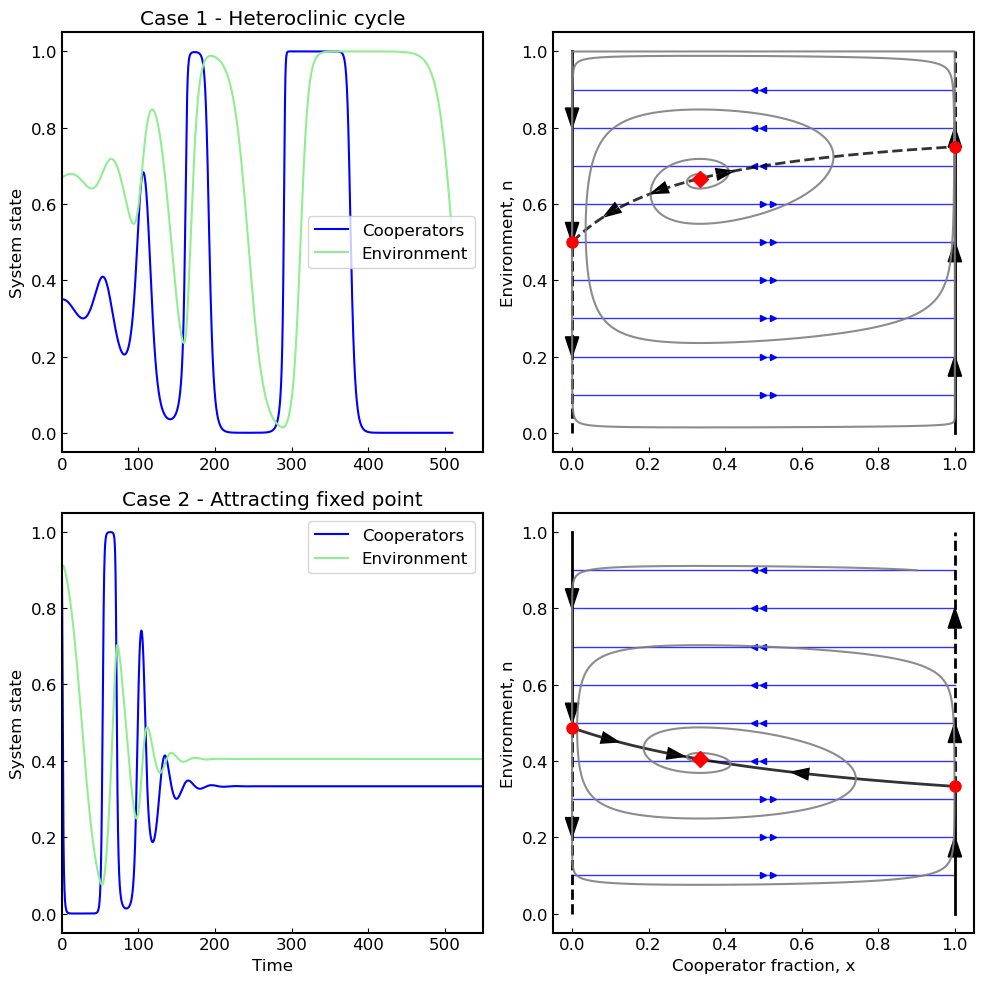

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def get_payoff_matrix(n, A0, A1):
    # Assymetric payoff matrix (Eq. 18).
    return (1 - n) * A0 + n * A1

def get_fast_parameters(n, A0, A1):
    """
    Calculates coefficients (a, b) for the fast dynamics equation:
    x' = x(1-x)(ax + b)
    """
    A = get_payoff_matrix(n, A0, A1)
    
    # Extract Payoffs: Row 0 (Coop), Row 1 (Defect)
    R, S = A[0, 0], A[0, 1]
    T, P = A[1, 0], A[1, 1]
    
    # b = S - P
    # a = (R - T) - (S - P)
    b = S - P
    a = (R - T) - b
    
    return a, b

def dynamics_general(t, y, epsilon, theta, A0, A1):
    """
    System Differential Equations (Paper Eq. 20).
    """
    x, n = y
    
    # --- 1. Fast Variable Dynamics (x) ---
    # We use the General Matrix Form (Eq. 4 & 5) applied to the interpolated matrix.
    # Note: We do NOT use Eq. 15 (symmetric shortcut) as Fig 3 uses asymmetric matrices.
    a, b = get_fast_parameters(n, A0, A1)
    
    # x' = x(1-x)(r1 - r2) 
    # Substituting (r1 - r2) = ax + b derived from the matrix.
    dxdt = x * (1 - x) * (a * x + b)
    
    # --- 2. Slow Variable Dynamics (n) ---
    # n' = epsilon * n(1-n) * (-1 + (1+theta)x)
    dndt = epsilon * n * (1 - n) * (-1 + (1 + theta) * x)
    
    return [dxdt, dndt]

# ============================================================================
# 2. PLOTTING HELPERS
# ============================================================================

def plot_fast_fibers(ax, A0, A1):
    """Draws horizontal blue lines (Fast Dynamics) with direction markers."""
    n_levels = np.linspace(0.1, 0.9, 9)
    
    for n in n_levels:
        # Draw fiber
        ax.plot([0, 1], [n, n], color='blue', lw=1, alpha=0.8)
        
        # Calculate flow direction
        a, b = get_fast_parameters(n, A0, A1)
        dx_mid = a * 0.5 + b  # Check direction at midpoint
        
        # Add Double Arrows (>>)
        marker = '>' if dx_mid > 0 else '<'
        ax.plot(0.5, n, marker=marker, color='blue', markersize=4)
        offset = 0.025 if dx_mid > 0 else -0.025
        ax.plot(0.5 + offset, n, marker=marker, color='blue', markersize=4)

def plot_boundary_manifolds(ax, A0, A1):
    """
    Plots vertical boundaries x=0 and x=1.
    - Solid Line: Stable equilibrium in fast dynamics.
    - Dashed Line: Unstable equilibrium.
    - Swaps style exactly at bifurcation points.
    """
    n_space = np.linspace(0, 1, 500)
    
    # --- Boundary x = 0 (Defectors) ---
    # Stable if S < P (i.e., b < 0)
    segments = []
    current_seg = {'n': [], 'stable': None}
    
    for n in n_space:
        _, b = get_fast_parameters(n, A0, A1)
        is_stable = (b < 0)
        
        if current_seg['stable'] is not None and current_seg['stable'] != is_stable:
            segments.append(current_seg)
            current_seg = {'n': [], 'stable': is_stable}
        elif current_seg['stable'] is None:
            current_seg['stable'] = is_stable
        current_seg['n'].append(n)
    segments.append(current_seg)
    
    for seg in segments:
        if not seg['n']: continue
        style = '-' if seg['stable'] else '--'
        ax.plot(np.zeros_like(seg['n']), seg['n'], color='k', ls=style, lw=2)

    # Add Vertical Arrows (Always Down for x=0)
    for y in [0.2, 0.5, 0.8]:
        ax.arrow(0, y, 0, -0.001, head_width=0.035, color='k', length_includes_head=True)

    # --- Boundary x = 1 (Cooperators) ---
    # Stable if R > T (i.e., a+b > 0)
    segments = []
    current_seg = {'n': [], 'stable': None}
    
    for n in n_space:
        a, b = get_fast_parameters(n, A0, A1)
        is_stable = (a + b > 0)
        
        if current_seg['stable'] is not None and current_seg['stable'] != is_stable:
            segments.append(current_seg)
            current_seg = {'n': [], 'stable': is_stable}
        elif current_seg['stable'] is None:
            current_seg['stable'] = is_stable
        current_seg['n'].append(n)
    segments.append(current_seg)
    
    for seg in segments:
        if not seg['n']: continue
        style = '-' if seg['stable'] else '--'
        ax.plot(np.ones_like(seg['n']), seg['n'], color='k', ls=style, lw=2)

    # Add Vertical Arrows (Always Up for x=1)
    for y in [0.2, 0.5, 0.8]:
        ax.arrow(1, y, 0, 0.001, head_width=0.035, color='k', length_includes_head=True)

def plot_interior_manifold(ax, theta, A0, A1):
    """
    Plots the curved interior manifold where x' = 0.
    - Solid: Stable attractor.
    - Dashed: Unstable repeller.
    - Includes arrows indicating slow flow direction along the curve.
    """
    n_space = np.linspace(0.01, 0.99, 600)
    segments = []
    current_seg = {'x': [], 'n': [], 'stable': None}
    
    for n in n_space:
        a, b = get_fast_parameters(n, A0, A1)
        
        if abs(a) < 1e-6: continue # Avoid division by zero
        x_c = -b / a
        
        if 0 <= x_c <= 1:
            is_stable = (a < 0) # Stability condition
            
            # Start new segment if stability changes
            if current_seg['stable'] is not None and current_seg['stable'] != is_stable:
                segments.append(current_seg)
                current_seg = {'x': [], 'n': [], 'stable': is_stable}
            elif current_seg['stable'] is None:
                current_seg['stable'] = is_stable
            
            current_seg['x'].append(x_c)
            current_seg['n'].append(n)
        else:
            # Manifold exits the domain [0,1]
            if current_seg['x']:
                segments.append(current_seg)
                current_seg = {'x': [], 'n': [], 'stable': None}
                
    if current_seg['x']: segments.append(current_seg)
    
    # Draw segments
    for seg in segments:
        if not seg['x']: continue
        style = '-' if seg['stable'] else '--'
        ax.plot(seg['x'], seg['n'], color='k', ls=style, lw=2, alpha=0.8)
        
        # Add Directional Arrows along the curve
        indices = [int(len(seg['x']) * p) for p in [0.25, 0.5, 0.75]]
        for idx in indices:
            if idx <= 1 or idx >= len(seg['x'])-1: continue
            
            x_p, n_p = seg['x'][idx], seg['n'][idx]
            
            # Slow flow direction: n' ~ -1 + (1+theta)x
            slow_val = -1 + (1 + theta) * x_p
            
            # Get tangent vector (dx, dn) from the arrays
            dx = seg['x'][idx+1] - seg['x'][idx-1]
            dn = seg['n'][idx+1] - seg['n'][idx-1]
            
            # n increases in our array. 
            # If slow_val < 0 (flow down), reverse the tangent vector.
            if slow_val < 0:
                dx, dn = -dx, -dn
                
            ax.arrow(x_p, n_p, dx*0.001, dn*0.001, shape='full', lw=0, 
                     length_includes_head=True, head_width=0.035, color='k', zorder=20)

def find_bifurcations(A0, A1):
    """Finds intersection points of the interior manifold with boundaries."""
    bifs = []
    a0, b0 = get_fast_parameters(0, A0, A1)
    a1, b1 = get_fast_parameters(1, A0, A1)
    
    # Intersection with x=0 (where b=0)
    denom = b1 - b0
    if abs(denom) > 1e-9:
        n0 = -b0 / denom
        if 0 <= n0 <= 1: bifs.append((0, n0))
            
    # Intersection with x=1 (where a+b=0)
    denom = (a1+b1) - (a0+b0)
    if abs(denom) > 1e-9:
        n1 = -(a0+b0) / denom
        if 0 <= n1 <= 1: bifs.append((1, n1))
    return bifs

# ============================================================================
# 3. MAIN EXECUTION
# ============================================================================

def reproduce_figure_3():
    
    # Shared Parameters
    epsilon = 0.1
    theta = 2.0
    
    # --- Case 1: Heteroclinic Cycle ---
    A0_het = np.array([[3.5, 1.0], [2.0, 0.75]])
    A1_het = np.array([[4.0, 1.0], [4.5, 1.25]])
    y0_het = [0.35, 0.67] # Initial condition
    
    sol_het = solve_ivp(dynamics_general, (0, 510), y0_het, 
                        args=(epsilon, theta, A0_het, A1_het), 
                        rtol=1e-10, atol=1e-13, max_step=0.01)

    # --- Case 2: Attracting Fixed Point ---
    A0_fix = np.array([[3.5, 1.0], [2.0, 0.05]])
    A1_fix = np.array([[4.0, 1.0], [7.0, 2.0]])
    y0_fix = [0.9, 0.9] # Initial condition
    
    sol_fix = solve_ivp(dynamics_general, (0, 550), y0_fix, 
                        args=(epsilon, theta, A0_fix, A1_fix), 
                        rtol=1e-10, atol=1e-13, max_step=0.1)

    # --- Plotting ---
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    # [Top Left] Case 1 Time Series
    axes[0,0].plot(sol_het.t, sol_het.y[0], label='Cooperators', color="blue")
    axes[0,0].plot(sol_het.t, sol_het.y[1], label='Environment', color="lightgreen")
    axes[0,0].set_title('Case 1 - Heteroclinic cycle')
    axes[0,0].set_ylabel('System state')
    axes[0,0].set_xlim(0, 550)
    axes[0,0].legend()

    # [Top Right] Case 1 Phase Plane
    ax1 = axes[0,1]
    plot_fast_fibers(ax1, A0_het, A1_het)
    plot_boundary_manifolds(ax1, A0_het, A1_het)
    plot_interior_manifold(ax1, theta, A0_het, A1_het)
    
    # Markers (Bifurcations & Repeller)
    for bx, bn in find_bifurcations(A0_het, A1_het):
        ax1.plot(bx, bn, 'ro', zorder=20, markersize=8)
    
    # Repeller (Approx location derived from theta)
    ax1.plot(1/(1+theta), 2/3, marker='D', color='red', markersize=8, zorder=30)
    
    # Trajectory
    ax1.plot(sol_het.y[0], sol_het.y[1], color='grey', lw=1.5, alpha=0.9)
    ax1.set_xlim(-0.05, 1.05); ax1.set_ylim(-0.05, 1.05)
    ax1.set_ylabel('Environment, n')

    # [Bottom Left] Case 2 Time Series
    axes[1,0].plot(sol_fix.t, sol_fix.y[0], label='Cooperators', color="blue")
    axes[1,0].plot(sol_fix.t, sol_fix.y[1], label='Environment', color="lightgreen")
    axes[1,0].set_title('Case 2 - Attracting fixed point')
    axes[1,0].set_ylabel('System state')
    axes[1,0].set_xlabel('Time')
    axes[1,0].set_xlim(0, 550)
    axes[1,0].legend()

    # [Bottom Right] Case 2 Phase Plane
    ax2 = axes[1,1]
    plot_fast_fibers(ax2, A0_fix, A1_fix)
    plot_boundary_manifolds(ax2, A0_fix, A1_fix)
    plot_interior_manifold(ax2, theta, A0_fix, A1_fix)
    
    # Markers (Bifurcations & Attractor)
    for bx, bn in find_bifurcations(A0_fix, A1_fix):
        ax2.plot(bx, bn, 'ro', zorder=20, markersize=8)
        
    ax2.plot(sol_fix.y[0][-1], sol_fix.y[1][-1], marker='D', color='red', 
             markersize=8, zorder=30)
    
    # Trajectory
    ax2.plot(sol_fix.y[0], sol_fix.y[1], color='grey', lw=1.5, alpha=0.9)
    ax2.set_xlim(-0.05, 1.05); ax2.set_ylim(-0.05, 1.05)
    ax2.set_xlabel('Cooperator fraction, x')
    ax2.set_ylabel('Environment, n')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    reproduce_figure_3()

<>:96: SyntaxWarning: invalid escape sequence '\e'
<>:107: SyntaxWarning: invalid escape sequence '\e'
<>:96: SyntaxWarning: invalid escape sequence '\e'
<>:107: SyntaxWarning: invalid escape sequence '\e'
C:\Users\rayan\AppData\Local\Temp\ipykernel_20300\2358461533.py:96: SyntaxWarning: invalid escape sequence '\e'
  ax_left.text(0.03, 0.08, f'$\epsilon = {eps}$', transform=ax_left.transAxes, fontsize=11)
C:\Users\rayan\AppData\Local\Temp\ipykernel_20300\2358461533.py:107: SyntaxWarning: invalid escape sequence '\e'
  ax_right.text(0.03, 0.08, f'$\epsilon = {eps}$', transform=ax_right.transAxes, fontsize=11)


Generating Figure 4...


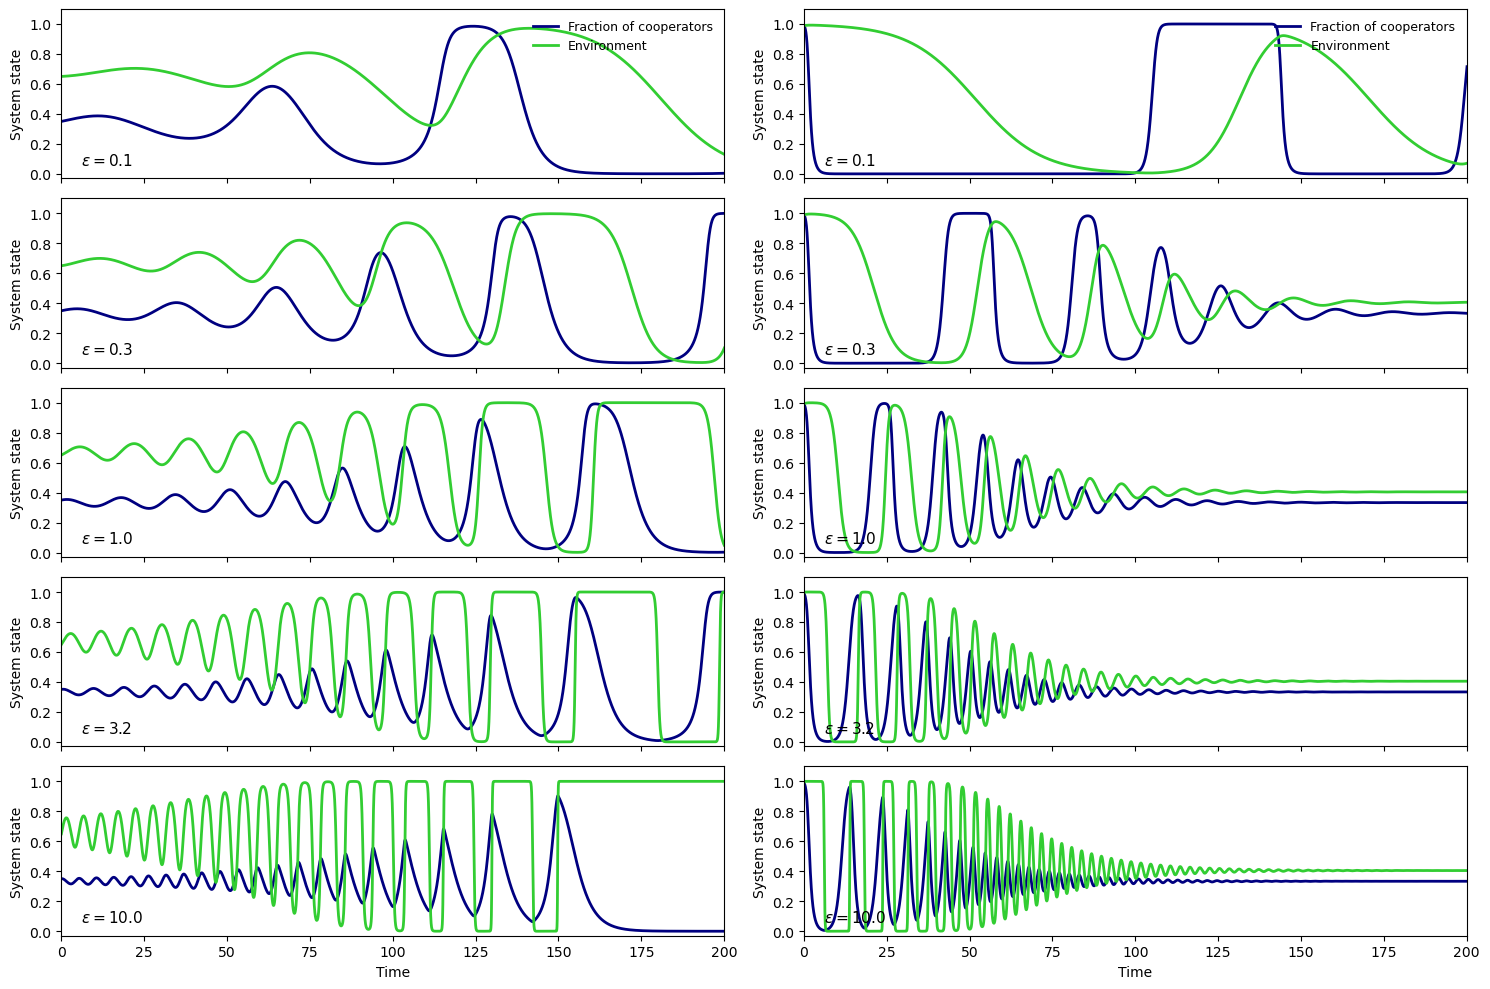

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ============================================================================
# 1. DYNAMICS ENGINE
# ============================================================================

def get_payoff_matrix(n, A0, A1):
    """
    Interpolate payoff matrix: A(n) = (1-n)A0 + nA1
    """
    return (1 - n) * A0 + n * A1

def get_fast_parameters(n, A0, A1):
    """
    Helper to calculate linear fitness coefficients a, b.
    (r1 - r2) = ax + b
    """
    A = get_payoff_matrix(n, A0, A1)
    
    # Row 0: Cooperators (R, S)
    # Row 1: Defectors   (T, P)
    R, S = A[0, 0], A[0, 1]
    T, P = A[1, 0], A[1, 1]
    
    # Derived from: (Rx + S(1-x)) - (Tx + P(1-x))
    b = S - P
    a = (R - T) - b
    
    return a, b

def dynamics_general(t, y, epsilon, theta, A0, A1):
    """
    System Differential Equations (Paper Eq. 20).
    """
    x, n = y
    
    # --- 1. Fast Variable Dynamics (x) ---
    # We use the General Matrix Form (Eq. 4 & 5) applied to the interpolated matrix.
    # Note: We do NOT use Eq. 15 (symmetric shortcut) as Fig 3 uses asymmetric matrices.
    a, b = get_fast_parameters(n, A0, A1)
    
    # x' = x(1-x)(r1 - r2) 
    # Substituting (r1 - r2) = ax + b derived from the matrix.
    dxdt = x * (1 - x) * (a * x + b)
    
    # --- 2. Slow Variable Dynamics (n) ---
    # n' = epsilon * n(1-n) * (-1 + (1+theta)x)
    dndt = epsilon * n * (1 - n) * (-1 + (1 + theta) * x)
    
    return [dxdt, dndt]
# ============================================================================
# 2. FIGURE 4 REPRODUCTION
# ============================================================================

def reproduce_figure_4():
    print("Generating Figure 4...")
    
    # --- Parameters ---
    epsilon_values = [0.1, 0.3, 1.0, 3.2, 10.0]  # Rows of the plot
    theta = 2.0
    t_span = (0, 200)  # Time duration
    
    # --- Matrices ---
    # Left Column: Heteroclinic Cycle (Oscillating)
    A0_het = np.array([[3.5, 1.0], [2.0, 0.75]])
    A1_het = np.array([[4.0, 1.0], [4.5, 1.25]])
    y0_het = [0.35, 0.65] 
    
    # Right Column: Interior Fixed Point (Stable)
    A0_fix = np.array([[3.5, 1.0], [2.0, 0.05]])
    A1_fix = np.array([[4.0, 1.0], [7.0, 2.0]])
    y0_fix = [0.99, 0.99]

    # --- Plot Setup ---
    # 5 Rows, 2 Columns
    fig, axes = plt.subplots(len(epsilon_values), 2, figsize=(15, 10), sharex=True)
    
    # Colors matching the paper
    color_coop = '#000080'  # Navy Blue
    color_env = '#32CD32'   # Lime Green

    for i, eps in enumerate(epsilon_values):
        
        # --- Left Column: Heteroclinic ---
        sol_het = solve_ivp(dynamics_general, t_span, y0_het,
                            args=(eps, theta, A0_het, A1_het),
                            rtol=1e-10, atol=1e-13, max_step=0.1)
        
        ax_left = axes[i, 0]
        ax_left.plot(sol_het.t, sol_het.y[0], color=color_coop, lw=2)
        ax_left.plot(sol_het.t, sol_het.y[1], color=color_env, lw=2)
        
        # Text Label (e.g., "epsilon = 0.1")
        ax_left.text(0.03, 0.08, f'$\epsilon = {eps}$', transform=ax_left.transAxes, fontsize=11)
        
        # --- Right Column: Fixed Point ---
        sol_fix = solve_ivp(dynamics_general, t_span, y0_fix,
                            args=(eps, theta, A0_fix, A1_fix),
                            rtol=1e-10, atol=1e-13, max_step=0.1)
        
        ax_right = axes[i, 1]
        ax_right.plot(sol_fix.t, sol_fix.y[0], color=color_coop, lw=2)
        ax_right.plot(sol_fix.t, sol_fix.y[1], color=color_env, lw=2)
        
        ax_right.text(0.03, 0.08, f'$\epsilon = {eps}$', transform=ax_right.transAxes, fontsize=11)

        # --- Formatting for both columns ---
        for ax in [ax_left, ax_right]:
            ax.set_ylim(-0.03, 1.1)
            ax.set_ylabel('System state')
            
            # Add the requested space left of 0 and right of 200
            ax.set_xlim(0, 200)
            
            # Hide x-ticks for all but the bottom row
            if i < len(epsilon_values) - 1:
                ax.tick_params(labelbottom=False)

    # --- Final Touches ---
    # Legends on top row only
    axes[0, 0].legend(['Fraction of cooperators', 'Environment'], 
                      loc='upper right', frameon=False, fontsize=9)
    axes[0, 1].legend(['Fraction of cooperators', 'Environment'], 
                      loc='upper right', frameon=False, fontsize=9)

    # X-labels on bottom row only
    axes[-1, 0].set_xlabel('Time')
    axes[-1, 1].set_xlabel('Time')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    reproduce_figure_4()